In [67]:
import numpy as np
import pandas as pd
import itertools
import pylab as plt

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [ ]:
# Ответ на вопрос 1

In [2]:
# Ответ на вопрос 2


## Задание 4

In [14]:
l = np.array([49,58,75,110,112,132,151,276,281,362])

In [15]:
stats.wilcoxon(l-200)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

In [17]:
# Ответ задание 4
round(0.2845026979112075, 4)

0.2845

## Задание 5

In [18]:
rubit = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
ne_rubit = np.array([17,18,18,15,12,4,14,15,10])

In [19]:
stats.mannwhitneyu(rubit, ne_rubit)

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)

In [20]:
# Ответ задание 5
round(0.02900499272087373, 4)

0.029

## Задание 6

In [26]:
data = pd.read_csv('challenger.txt', sep='\t')
data.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [56]:
data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [44]:
inc_true = data['Temperature'][(data.Incident == 1)].values
inc_false = data['Temperature'][(data.Incident == 0)].values

In [34]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [35]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [40]:
get_bootstrap_samples(inc_true, 1)

array([[['Jan12.86', 14.4, 1],
        ['Aug30.84', 21.1, 1],
        ['Oct30.85', 23.9, 1],
        ['Jan12.86', 14.4, 1],
        ['Apr06.84', 17.2, 1],
        ['Jan12.86', 14.4, 1],
        ['Jan12.86', 14.4, 1]]], dtype=object)

In [49]:
np.random.seed(0)
inc_true_scores = list(map(np.mean, get_bootstrap_samples(inc_true, 1000)))
inc_false_scores = list(map(np.mean, get_bootstrap_samples(inc_false, 1000)))

In [51]:
stat_intervals(inc_true_scores, 0.05)

array([14.61428571, 20.71607143])

In [50]:
stat_intervals(inc_false_scores, 0.05)

array([21.14359375, 23.55046875])

In [54]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(inc_true_scores, inc_false_scores)))

In [84]:
stat_intervals(delta_median_scores, 0.05)

array([1.45040179, 8.06457589])

In [85]:
# Ответ задание 6
round(1.45040179, 4)

1.4504

## Задание 7

In [59]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(map(lambda x: x - mean, sample))
    return t_stat

In [60]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = map(lambda x: x - mean, sample)
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

In [61]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

Далее расчет для несвязанных выборок:

In [62]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [75]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [76]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [77]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<function matplotlib.pyplot.show(*args, **kw)>

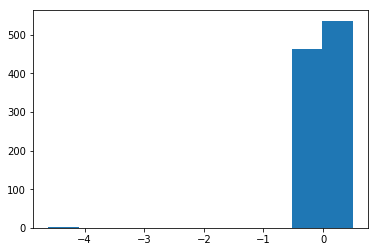

In [78]:
pylab.hist(permutation_zero_dist_ind(inc_true_scores, inc_false_scores, max_combinations = 1000))
plt.show

In [79]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [83]:
# Ответ задание 7
np.random.seed(0)
permutation_test(inc_true, inc_false, max_permutations = 10000)

0.0057